# Here is a procedure for making CNN model for AIMS captcha
https://aims.iith.ac.in/aims/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.applications import imagenet_utils
from keras import Model
import warnings
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image
%matplotlib inline

2023-01-22 12:20:12.491316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 12:20:15.099651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 12:20:15.099719: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 12:20:21.505617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
def get_data(nameDir):
    """
    ===================================
    This function will download 100 images per letter and digit, in the directory "nameDir".
    Downloaded images will consist of single digits
    Directory of small letters will be named as small{letter}. For e.g. smalla
    Similary, directory of small letters will be named as cap{letter}. For e.g. capA
    Directory of digits will be named as {digit}. For e.g. 1
    ===================================
    """
    import requests,os,cv2,shutil
    base="https://aims.iith.ac.in/aims/captcha/getCaptchaByString/"
    dir_path = os.path.join(os.getcwd(),nameDir)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path,0o666)
    for i in range(48,123):
        if ((i>=48 and i<=57) or (i>=65 and i<=90) or (i>=97 and i<=122)):
            ch=chr(i)
            if (i>=65 and i<=90):
                save_path=os.path.join(dir_path,f"cap{ch}")
            elif (i>=97 and i<=122):
                save_path=os.path.join(dir_path,f"small{ch}")
            else: save_path=os.path.join(dir_path,f"{ch}")
            if not os.path.exists(save_path):
                os.mkdir(save_path,mode=0o777)
            s=""
            for k in range(5):
                s+=ch
            url=base+s
            for j in range(20):
                # Fetch image from server
                r = requests.get(url, stream = True)
                if r.status_code == 200:
                    r.raw.decode_content = True
                    with open(os.path.join(save_path,f"{ch}#.jpg"),'wb') as f:
                        shutil.copyfileobj(r.raw, f)
                    img=cv2.imread(os.path.join(save_path,f"{ch}#.jpg"))
                    # Divide image in 5 parts and save each digit
                    height,width,c=img.shape
                    width_cutoff=width // 5
                    s1=img[:,:width_cutoff]
                    cv2.imwrite(f"{save_path}/{5*j+1}.jpg",s1)
                    for k in range(1,4):
                        s1=img[:,k*width_cutoff:(k+1)*width_cutoff]
                        cv2.imwrite(f"{save_path}/{5*j+k+1}.jpg",s1)
                    s1=img[:,4*width_cutoff:]
                    cv2.imwrite(f"{save_path}/{5*j+5}.jpg",s1)
                    os.remove(os.path.join(save_path,f"{ch}#.jpg"))
                else:
                    print(f'Image Couldn\'t be retreived: {ch}#.jpg')
    return

In [ ]:
# Download files
get_data("train")

In [5]:
# Make the val directory
if os.path.isdir('val/0') is False:
    os.mkdir('val/')
    li=listdir('train/')
    for i in li:
        os.mkdir(f'val/{i}/')
        tempLi=listdir(f'train/{i}/')
        for img in random.sample(tempLi,15):
            shutil.move(f'train/{i}/{img}',f'val/{i}/')

# Make the test directory
if os.path.isdir('test/0') is False:
    os.mkdir('test/')
    li = listdir('train/')
    for i in li:
        os.mkdir(f'test/{i}/')
        tempLi = listdir(f'train/{i}')
        for img in random.sample(tempLi,5):
            shutil.move(f'train/{i}/{img}',f'test/{i}/')

In [7]:
# Generation of train, validation and test data
train_path='train/'
valid_path='val/'
test_path='test/'
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path,
                                                                                                                           target_size=(50,30),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path,
                                                                                                                        target_size=(50,30),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path,
                                                                                                                        target_size=(50,30),batch_size=10, shuffle = False)

Found 4960 images belonging to 62 classes.
Found 930 images belonging to 62 classes.
Found 310 images belonging to 62 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

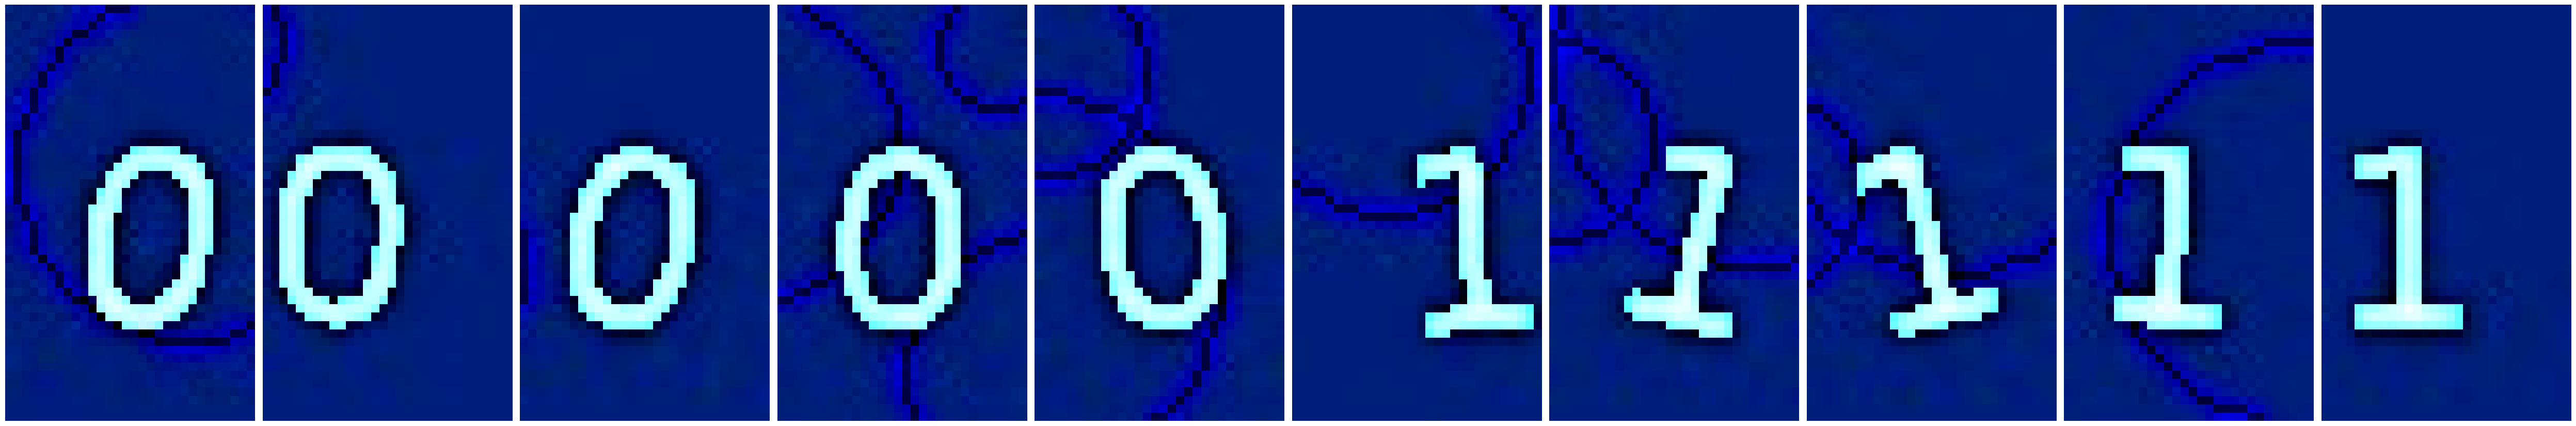

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [8]:
imgs, labels = next(test_batches)
def plotImages(images_arr):
    """
    Plot batch of images
    """
    fig, axes = plt.subplots(1, 10, figsize=(50,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

In [10]:
# Sequential model
model=Sequential([
    Conv2D(filters = 64, kernel_size = (4,4), activation='relu', padding = "same", input_shape=(50,30,3)),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
    Conv2D(filters = 128, kernel_size = (4,4), activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),
    Flatten(),
    Dense(units=62,activation='softmax')
])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 30, 64)        3136      
                                                                 
 batch_normalization_2 (Batc  (None, 50, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 25, 15, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 12, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 22, 12, 128)     

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x=train_batches,validation_data=valid_batches,epochs=15,verbose=2)

Epoch 1/15


2023-01-22 12:25:55.956507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 20545536 exceeds 10% of free system memory.
2023-01-22 12:25:55.957236: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 20545536 exceeds 10% of free system memory.
2023-01-22 12:25:55.995329: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 13248000 exceeds 10% of free system memory.
2023-01-22 12:25:56.025022: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 20545536 exceeds 10% of free system memory.
2023-01-22 12:25:56.025080: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 20545536 exceeds 10% of free system memory.


496/496 - 79s - loss: 2.5200 - accuracy: 0.6367 - val_loss: 0.5362 - val_accuracy: 0.8624 - 79s/epoch - 160ms/step
Epoch 2/15
496/496 - 94s - loss: 0.3717 - accuracy: 0.9286 - val_loss: 0.2008 - val_accuracy: 0.9570 - 94s/epoch - 190ms/step
Epoch 3/15
496/496 - 86s - loss: 0.2493 - accuracy: 0.9522 - val_loss: 0.2488 - val_accuracy: 0.9409 - 86s/epoch - 172ms/step
Epoch 4/15
496/496 - 86s - loss: 0.1369 - accuracy: 0.9690 - val_loss: 0.2589 - val_accuracy: 0.9473 - 86s/epoch - 172ms/step
Epoch 5/15
496/496 - 26s - loss: 0.2292 - accuracy: 0.9625 - val_loss: 13.0321 - val_accuracy: 0.4151 - 26s/epoch - 53ms/step
Epoch 6/15
496/496 - 18s - loss: 0.2174 - accuracy: 0.9617 - val_loss: 0.1295 - val_accuracy: 0.9796 - 18s/epoch - 36ms/step
Epoch 7/15
496/496 - 18s - loss: 0.1331 - accuracy: 0.9790 - val_loss: 0.2734 - val_accuracy: 0.9570 - 18s/epoch - 36ms/step
Epoch 8/15
496/496 - 18s - loss: 0.1042 - accuracy: 0.9821 - val_loss: 0.0972 - val_accuracy: 0.9871 - 18s/epoch - 36ms/step
Epoch 

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

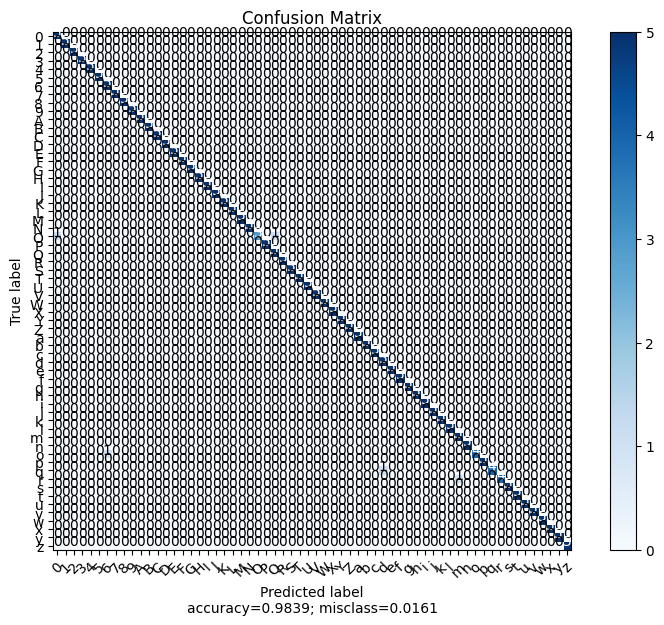

In [21]:
# Prediction and plotting confusion matrix
pred = model.predict(x=test_batches,verbose=0)
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(pred,axis=1))
plotLabels= []
for i in range(48,58):
    plotLabels.append(chr(i))
for i in range(65,91):
    plotLabels.append(chr(i))
for i in range(97,123):
    plotLabels.append(chr(i))
plot_confusion_matrix(cm=cm,target_names=plotLabels,title='Confusion Matrix',normalize=False)

In [14]:
def model_predict(fileName):
    """
    For prediction of real aims captcha images present in random_test directory
    """
    img = load_img(f'random_test/{fileName}', target_size=(50,150))
    img_arr = img_to_array(img)
    out = ""
    for i in range(5):
        img1 = img_arr[:,30*i:30*(i+1),:]
        
        img1 = keras.applications.mobilenet.preprocess_input(img1)
        img1 = img1.reshape((1, img1.shape[0], img1.shape[1], img1.shape[2]))
        pred=model.predict(img1,verbose=0)
        pred = np.rint(pred)
        ind = np.where(pred[0])[0][0]
        if (ind<10):
            out+=chr(ind+48)
        elif (ind<36):
            out+= chr(ind+55)
        else: out+= chr(ind+61)
    plt.imshow(img)
    print(f"Predicted string: {out}")
    plt.show()

Predicted string: 0oPQx


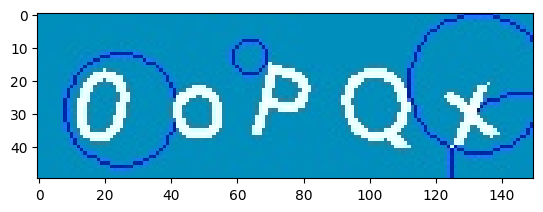

In [15]:
model_predict('7.jpeg')

Predicted string: 62FFK


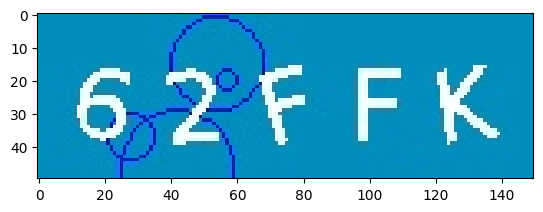

In [18]:
model_predict('1.jpeg')

Predicted string: 4eh5C


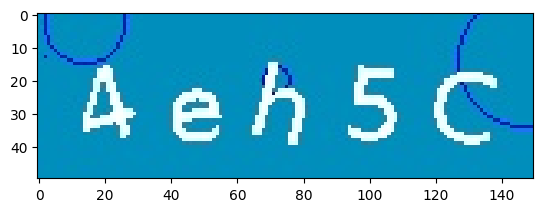

In [19]:
model_predict('9.jpeg')